This notebook demonstrates non-statistically significant increase of PCI for a reduced leak potassium conductance configuration compared to baseline. It also shows the intensity of the stimulation has little to no effect on the PCI value for the values tested.

In [23]:
%precision 2
%load_ext autoreload
%autoreload 2
import os
import itertools
import numpy as np
from tvbsim.receptors import conversion, get_g_K_values
from tvbsim.simconfig import SimConfig
from tvbsim.run_simulations import run_n_complete_parallelized
from tvbsim.parameter import ListParameter
from tvbsim.common import get_result
from tvbsim.plotting import plot_tvb_results, plot_box_points_violin
from tvbsim.PCI import parallelized_PCI
from tvbsim.TVB.tvb_model_reference.simulation_file.parameter.parameter_M_Berlin_new import Parameters

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup

Fix start and end (respectively before and after leak conductance reduction) reversal potential (E_L_e for excitatory population, E_L_i for inhibitory). Choose a connectome.

In [2]:
# general_parameters are parameters applied to all SimConfigs, instantiated with default values found in:
# tvbsim/TVB/tvb_model_reference/simulation_file/parameter/parameter_M_berlin_new
general_parameters = Parameters()

E_L_e_start = general_parameters.parameter_model['E_L_e']
E_L_i_start = general_parameters.parameter_model['E_L_i']
E_L_e_end = -61.2
E_L_i_end = -64.4

connectome = 'DK68' # 'Lausanne463'

In [8]:
run_sim = 8000.0
cut_transient = 4000.0

n_tasks_concurrent = 7

stop_conditions = [(1,0,-np.inf,150*1e-3,1500)]

max_seed = 30
n_minimal_seeds = 15

path = os.getcwd()
if connectome == 'DK68':
    general_parameters.parameter_connection_between_region['path'] = f'{path}/data/connectivity/DK68'
    general_parameters.parameter_connection_between_region['conn_name'] = 'connectivity_68_QL20120814.zip'
    receptors = np.loadtxt('./data/receptors/DK68/5HT2a_reordered.txt')
    stimregions = [5]
elif connectome == 'Lausanne463':
    general_parameters.parameter_connection_between_region['path'] = f'{path}/data/connectivity/Lausanne463'
    general_parameters.parameter_connection_between_region['conn_name'] = 'connectivity_cortical_Lausanne463.zip'
    receptors = np.loadtxt('./data/receptors/Lausanne463/5HT2A_Lausanne463_cortical.txt')
    stimregions = [252]
else:
    raise Exception('variable connectome should be either DK68 or Lausanne463')

stimvals = [0.25e-3, 0.5e-3, 0.75e-3, 1e-3] # IN KILO HERTZ
t_analysis = 300
n_trials = 5

# Generate a stimulation time for each seed
np.random.seed(0)
stimtime_allseeds = np.random.randint(cut_transient+t_analysis,
                                      run_sim-t_analysis,
                                      (max_seed,))
stimtime_allseeds = [int(i) for i in stimtime_allseeds]
param_change_with_seed = [{'stimtime':stimtime} for stimtime in stimtime_allseeds]

E_K_e = general_parameters.parameter_model['E_K_e']
E_K_i = general_parameters.parameter_model['E_K_i']
E_Na_e = general_parameters.parameter_model['E_Na_e']
E_Na_i = general_parameters.parameter_model['E_Na_i']
g_L = general_parameters.parameter_model['g_L']

g_K_e_nopsi,g_Na_e_nopsi = conversion(E_Na=E_Na_e, E_K=E_K_e, E_L=E_L_e_start, g_L=g_L)
g_K_e_psi,g_Na_e_psi = conversion(E_Na=E_Na_e, E_K=E_K_e, E_L=E_L_e_end, g_Na=g_Na_e_nopsi)
g_K_i_nopsi,g_Na_i_nopsi = conversion(E_Na=E_Na_i, E_K=E_K_i, E_L=E_L_i_start, g_L=g_L)
g_K_i_psi,g_Na_i_psi = conversion(E_Na=E_Na_i, E_K=E_K_i, E_L=E_L_i_end, g_Na=g_Na_i_nopsi)

params_nopsi = {'g_K_e':g_K_e_nopsi, 'g_Na_e':g_Na_e_nopsi, 'g_K_i':g_K_i_nopsi, 'g_Na_i':g_Na_i_nopsi}
params_psi = {
    'g_K_e':ListParameter('g_K_e', get_g_K_values(g_K_e_nopsi, g_K_e_psi, receptors=receptors), f'prop_{E_L_e_end}'),
    'g_K_i':ListParameter('g_K_i', get_g_K_values(g_K_i_nopsi, g_K_i_psi, receptors=receptors), f'prop_{E_L_i_end}'),
    'g_Na_e':g_Na_e_psi, 
    'g_Na_i':g_Na_i_psi}

simconfigs = []
for params in [params_nopsi,params_psi]:
    for stimregion,stimval in itertools.product(stimregions,stimvals):
        stim_params = {'stimval':stimval, 'stimregion':ListParameter('stimregion',[stimregion],str(stimregion)), 'stimdur':50}
        params_PCI = {**params, **stim_params}
        simconfigs.append(SimConfig(
            general_parameters=general_parameters,
            run_sim=run_sim,
            cut_transient=cut_transient,
            parameters=params_PCI,
            stop_conditions=stop_conditions,
            params_to_report=['g_K_e','g_K_i','g_Na_e','g_Na_i','stimval','stimregion','stimdur']))

simu_path = f'./result/{connectome}'
img_save_path = f'./img/{connectome}'

# Run simulations

In [9]:
noexp_seeds = np.zeros((len(simconfigs), n_minimal_seeds), dtype=int)
for i,simconfig in enumerate(simconfigs):
    noexp_seeds[i] = run_n_complete_parallelized(
        simconfig, max_seed=max_seed, save_path_root=simu_path, n_minimal_seeds=n_minimal_seeds, n_tasks_concurrent=n_tasks_concurrent,
        param_change_with_seed=param_change_with_seed)

path = path = path = path = path = path = path =     ./result/DK68/stim_0.00025_g_K_e_8.071428571428571_g_K_i_8.214285714285714_g_Na_e_1.9285714285714288_g_Na_i_1.7857142857142865_stimval_0.00025_stimregion_5_stimdur_50_6./result/DK68/stim_0.00025_g_K_e_8.071428571428571_g_K_i_8.214285714285714_g_Na_e_1.9285714285714288_g_Na_i_1.7857142857142865_stimval_0.00025_stimregion_5_stimdur_50_0  ./result/DK68/stim_0.00025_g_K_e_8.071428571428571_g_K_i_8.214285714285714_g_Na_e_1.9285714285714288_g_Na_i_1.7857142857142865_stimval_0.00025_stimregion_5_stimdur_50_1
 ./result/DK68/stim_0.00025_g_K_e_8.071428571428571_g_K_i_8.214285714285714_g_Na_e_1.9285714285714288_g_Na_i_1.7857142857142865_stimval_0.00025_stimregion_5_stimdur_50_3./result/DK68/stim_0.00025_g_K_e_8.071428571428571_g_K_i_8.214285714285714_g_Na_e_1.9285714285714288_g_Na_i_1.7857142857142865_stimval_0.00025_stimregion_5_stimdur_50_4

Initialize Simulator./result/DK68/stim_0.00025_g_K_e_8.071428571428571_g_K_i_8.214285714285714_g_Na_e

# Analysis

Loading:  ./result/DK68 stim_0.00025_g_K_e_8.071428571428571_g_K_i_8.214285714285714_g_Na_e_1.9285714285714288_g_Na_i_1.7857142857142865_stimval_0.00025_stimregion_5_stimdur_50_0
0
8000.0
END time 8000.0
Saving plot
g_K_e = 8.07, g_K_i = 8.21, g_Na_e = 1.93, g_Na_i = 1.79, stimval = 0.0, stimregion = 5, stimdur = 50


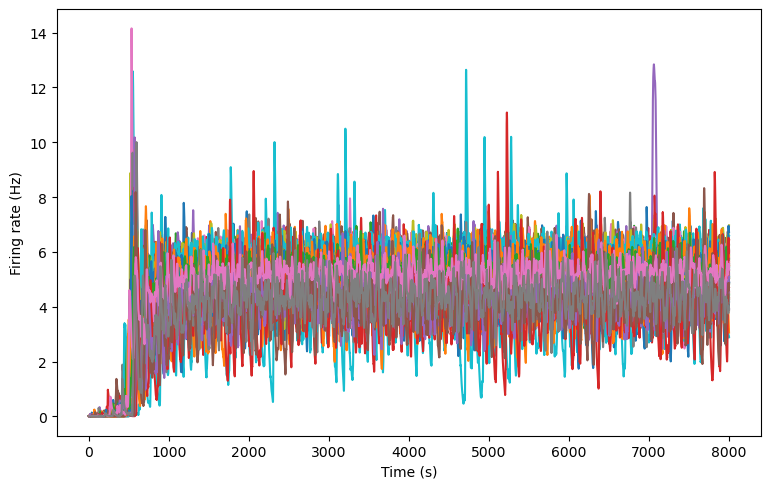

Loading:  ./result/DK68 stim_0.0005_g_K_e_8.071428571428571_g_K_i_8.214285714285714_g_Na_e_1.9285714285714288_g_Na_i_1.7857142857142865_stimval_0.0005_stimregion_5_stimdur_50_0
0
8000.0
END time 8000.0
Saving plot
g_K_e = 8.07, g_K_i = 8.21, g_Na_e = 1.93, g_Na_i = 1.79, stimval = 0.0, stimregion = 5, stimdur = 50


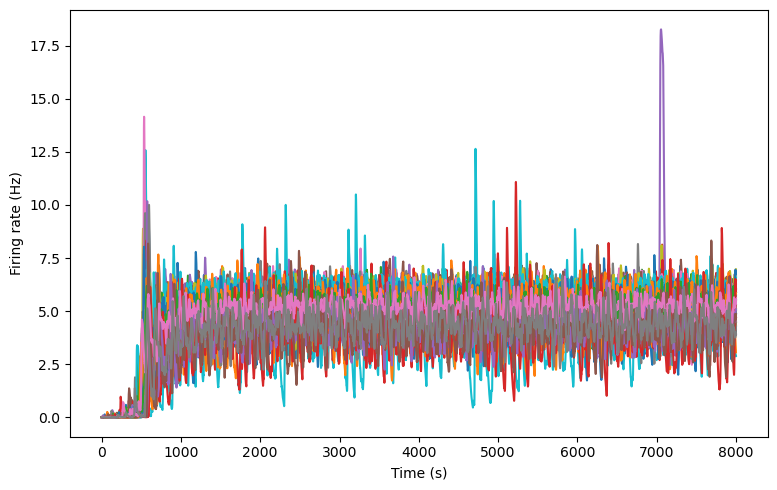

Loading:  ./result/DK68 stim_0.00075_g_K_e_8.071428571428571_g_K_i_8.214285714285714_g_Na_e_1.9285714285714288_g_Na_i_1.7857142857142865_stimval_0.00075_stimregion_5_stimdur_50_0
0
8000.0
END time 8000.0
Saving plot
g_K_e = 8.07, g_K_i = 8.21, g_Na_e = 1.93, g_Na_i = 1.79, stimval = 0.0, stimregion = 5, stimdur = 50


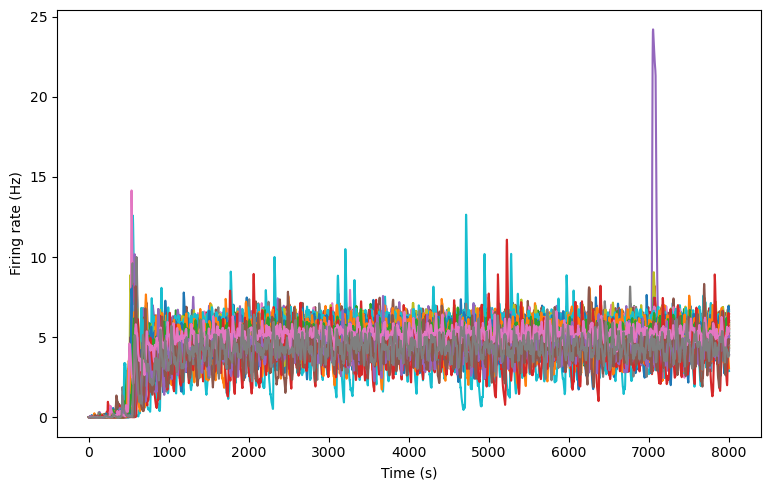

Loading:  ./result/DK68 stim_0.001_g_K_e_8.071428571428571_g_K_i_8.214285714285714_g_Na_e_1.9285714285714288_g_Na_i_1.7857142857142865_stimval_0.001_stimregion_5_stimdur_50_0
0
8000.0
END time 8000.0
Saving plot
g_K_e = 8.07, g_K_i = 8.21, g_Na_e = 1.93, g_Na_i = 1.79, stimval = 0.0, stimregion = 5, stimdur = 50


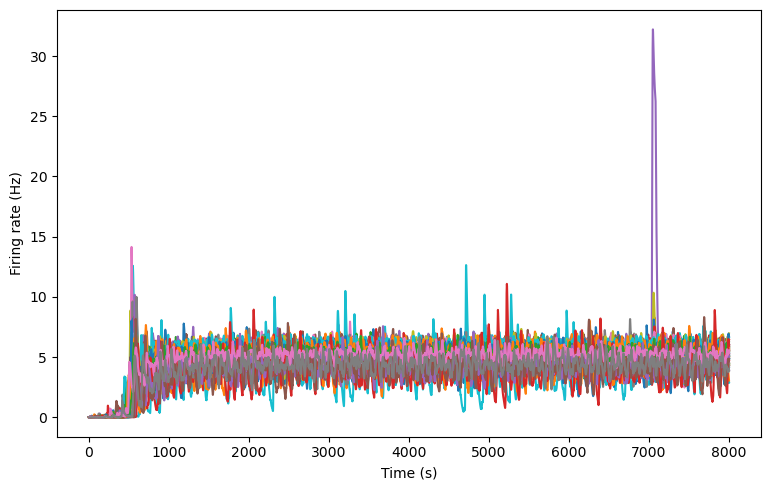

Loading:  ./result/DK68 stim_0.00025_g_K_e_prop_-61.2_g_K_i_prop_-64.4_g_Na_e_1.9285714285714288_g_Na_i_1.7857142857142865_stimval_0.00025_stimregion_5_stimdur_50_0
0
8000.0
END time 8000.0
Saving plot
g_K_e = prop_-61.2, g_K_i = prop_-64.4, g_Na_e = 1.93, g_Na_i = 1.79, stimval = 0.0, stimregion = 5, stimdur = 50


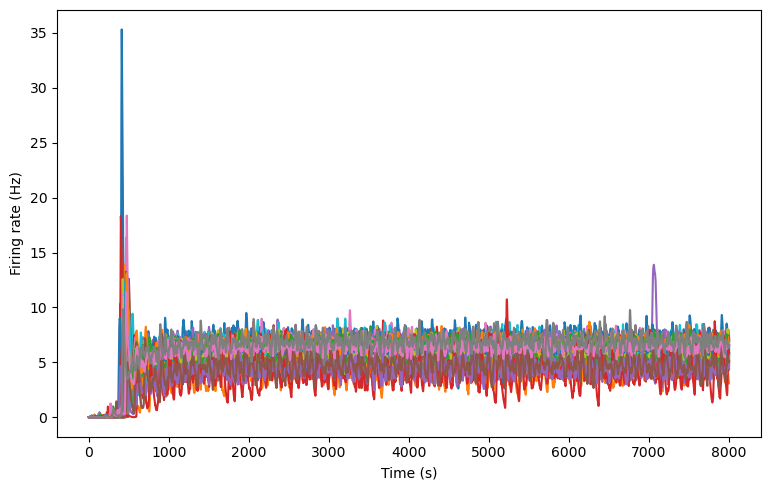

Loading:  ./result/DK68 stim_0.0005_g_K_e_prop_-61.2_g_K_i_prop_-64.4_g_Na_e_1.9285714285714288_g_Na_i_1.7857142857142865_stimval_0.0005_stimregion_5_stimdur_50_0
0
8000.0
END time 8000.0
Saving plot
g_K_e = prop_-61.2, g_K_i = prop_-64.4, g_Na_e = 1.93, g_Na_i = 1.79, stimval = 0.0, stimregion = 5, stimdur = 50


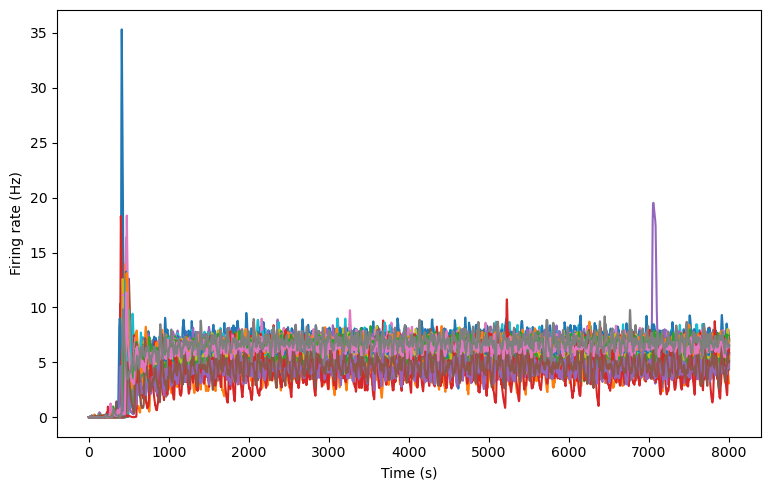

Loading:  ./result/DK68 stim_0.00075_g_K_e_prop_-61.2_g_K_i_prop_-64.4_g_Na_e_1.9285714285714288_g_Na_i_1.7857142857142865_stimval_0.00075_stimregion_5_stimdur_50_0
0
8000.0
END time 8000.0
Saving plot
g_K_e = prop_-61.2, g_K_i = prop_-64.4, g_Na_e = 1.93, g_Na_i = 1.79, stimval = 0.0, stimregion = 5, stimdur = 50


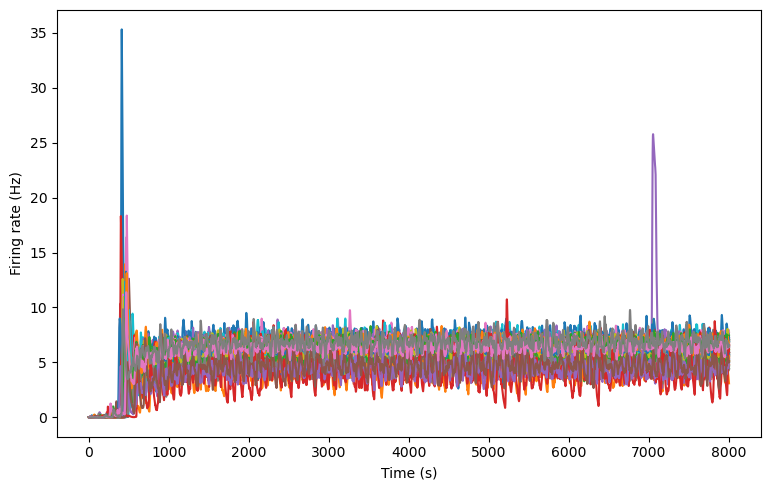

Loading:  ./result/DK68 stim_0.001_g_K_e_prop_-61.2_g_K_i_prop_-64.4_g_Na_e_1.9285714285714288_g_Na_i_1.7857142857142865_stimval_0.001_stimregion_5_stimdur_50_0
0
8000.0
END time 8000.0
Saving plot
g_K_e = prop_-61.2, g_K_i = prop_-64.4, g_Na_e = 1.93, g_Na_i = 1.79, stimval = 0.0, stimregion = 5, stimdur = 50


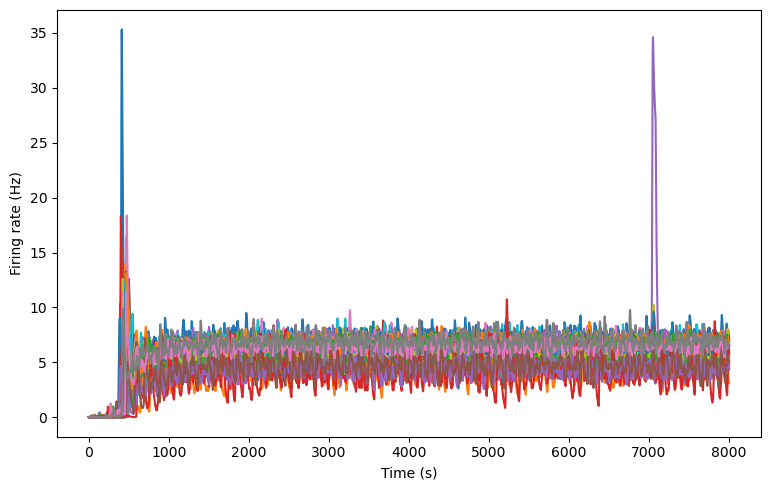

In [15]:
# Which variables to load ('E' is excitatory, the only variable saved by default 
# This can be changed in general_parameters.parameter_monitor['parameter_Raw']['variables_of_interest'] by adding 1,2,3 etc
# The list of variables of the model can be found in the documentation of get_result in tvbsim.common
vars_int = ['E']
monitor = 'Raw'
for i,simconfig in enumerate(simconfigs):
    result, for_explan = get_result(
        simconfig, seed=noexp_seeds[i][0], time_begin=0., vars_int=vars_int, simu_path=simu_path)
    plot_tvb_results([simconfig], [[result]], monitor, for_explan, vars_int, seeds=noexp_seeds[i][:1], 
                     figsize=(15,5), save=1, begin_time=4.,
                     priority_regions=[0], save_path=img_save_path, regions=None, with_title=False)

In [18]:
# Compute PCI
pcis = np.zeros((len(simconfigs),n_minimal_seeds))
for j,simconfig in enumerate(simconfigs):
    pcis[j] = parallelized_PCI(
        simconfig, noexp_seeds[j], n_tasks_concurrent=n_tasks_concurrent,
        t_analysis=t_analysis, n_trials=n_trials, simu_path=simu_path, save=1, save_path=simu_path)

No files found.
EntropyEntropyEntropy  0.28678041814411970.30730011453095896 

0.24941527242777134
Lempel-Ziv 1685
PCI 0.3235709648742616
Entropy 0.24281242800513303
Lempel-Ziv 1892
PCI 0.3159834381592543
Entropy 0.25874104279792204
Lempel-Ziv 2188
PCI 0.341017979864718
Entropy 0.2920579705845281
Lempel-Ziv 1487
PCI 0.29331396360732376
Entropy 0.2427060548215364
Lempel-Ziv 1876
PCI 0.3472643424928604
Entropy 0.21797574872523584
Lempel-Ziv 2138
PCI 0.3506156680328922
Entropy 0.2921013927973671
Lempel-Ziv 1711
PCI 0.33764636648485047
Entropy 0.23971935803506006
Lempel-Ziv 1725
PCI 0.379030015421348
Entropy 0.27175027847863237
Lempel-Ziv 1752
PCI 0.28727190601150276
Entropy 0.25916604353837014
Lempel-Ziv 1576
PCI 0.31488051640695464
Entropy 0.2427769725224206
Lempel-Ziv 1906
PCI 0.33592751734952436
Entropy 0.2187542576725694
Lempel-Ziv 2014
PCI 0.3721980121246889
Entropy 0.24593552004942887
Lempel-Ziv 1687
PCI 0.3328129932039485
Lempel-Ziv 1841
PCI 0.40307879890052
Lempel-Ziv 1779
PCI 0.3

In [20]:
print(simconfigs[1])
print(simconfigs[5])

run_sim = 8000.0, cut_transient = 4000.0
custom parameters = {'g_K_e': 8.071428571428571, 'g_Na_e': 1.9285714285714288, 'g_K_i': 8.214285714285714, 'g_Na_i': 1.7857142857142865, 'stimval': 0.0005, 'stimregion': <tvbsim.parameter.ListParameter object at 0x7f3b788e1450>, 'stimdur': 50}
special parameters = ['stimregion']
run_sim = 8000.0, cut_transient = 4000.0
custom parameters = {'g_K_e': <tvbsim.parameter.ListParameter object at 0x7f3b76c35420>, 'g_K_i': <tvbsim.parameter.ListParameter object at 0x7f3b76c356c0>, 'g_Na_e': 1.9285714285714288, 'g_Na_i': 1.7857142857142865, 'stimval': 0.0005, 'stimregion': <tvbsim.parameter.ListParameter object at 0x7f3b788e0a90>, 'stimdur': 50}
special parameters = ['g_K_e', 'g_K_i', 'stimregion']


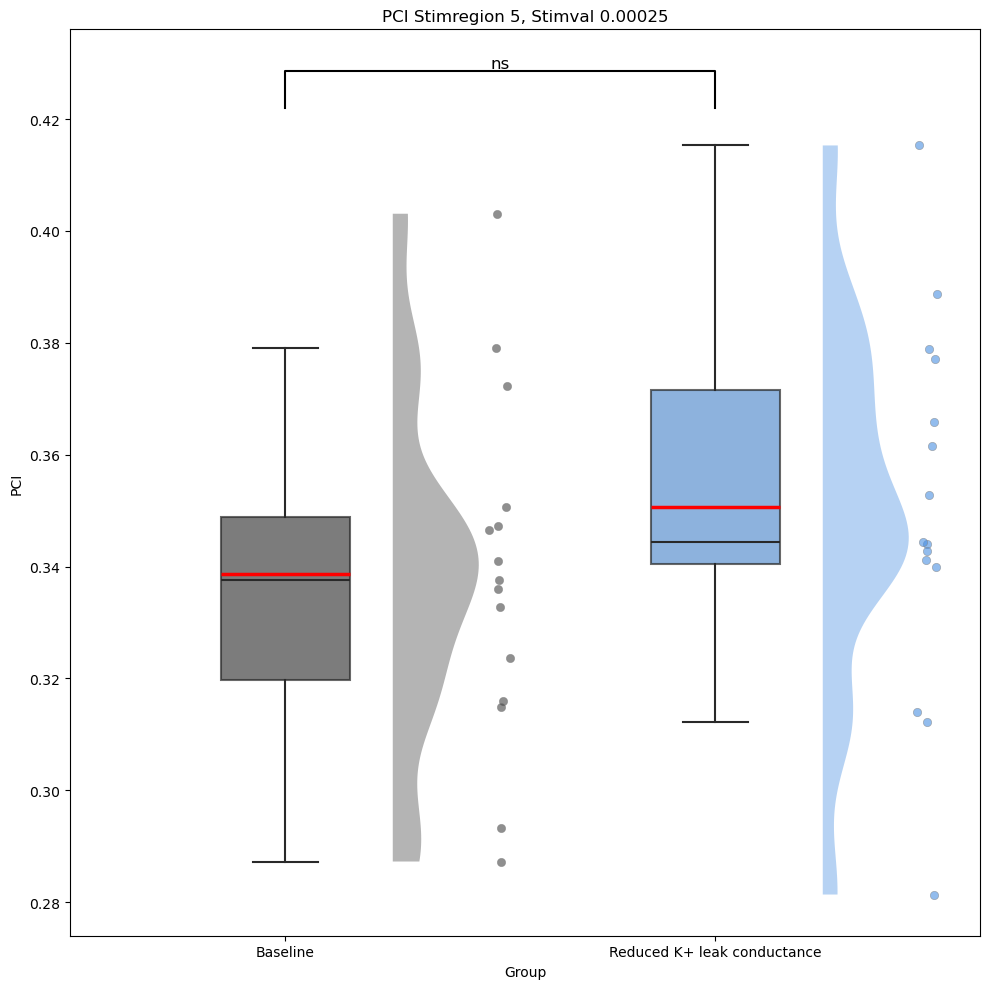

In [36]:
# Plot PCI for simval 0.5

stimval_idx = 0

set_params = {
    'title': f'PCI Stimregion {stimregion}, Stimval {stimvals[stimval_idx]}',
    'ylabel': 'PCI',
    'xlabel': 'Group'
}
x = ['Baseline','Reduced K+ leak conductance']
colors = ['#444444', '#4A90E2']
figsize = (10,10)

plot_box_points_violin(
    simconfigs=[simconfigs[stimval_idx],simconfigs[stimval_idx+len(stimvals)]],
    file_prefix='PCI',
    data=pcis[[stimval_idx,stimval_idx+len(stimvals)]],
    n_seeds=n_minimal_seeds,
    figsize=figsize,
    save=1,
    path=simu_path,
    x=x,
    save_path=img_save_path,
    file_name=f'PCI_stimval_{stimvals[stimval_idx]}.png',
    box_colors=colors,
    set_params=set_params
)

In [39]:
np.mean(pcis, axis=1)

array([0.33873786, 0.33245655, 0.3281747 , 0.32305601, 0.35068542,
       0.34431503, 0.33915082, 0.33300534])

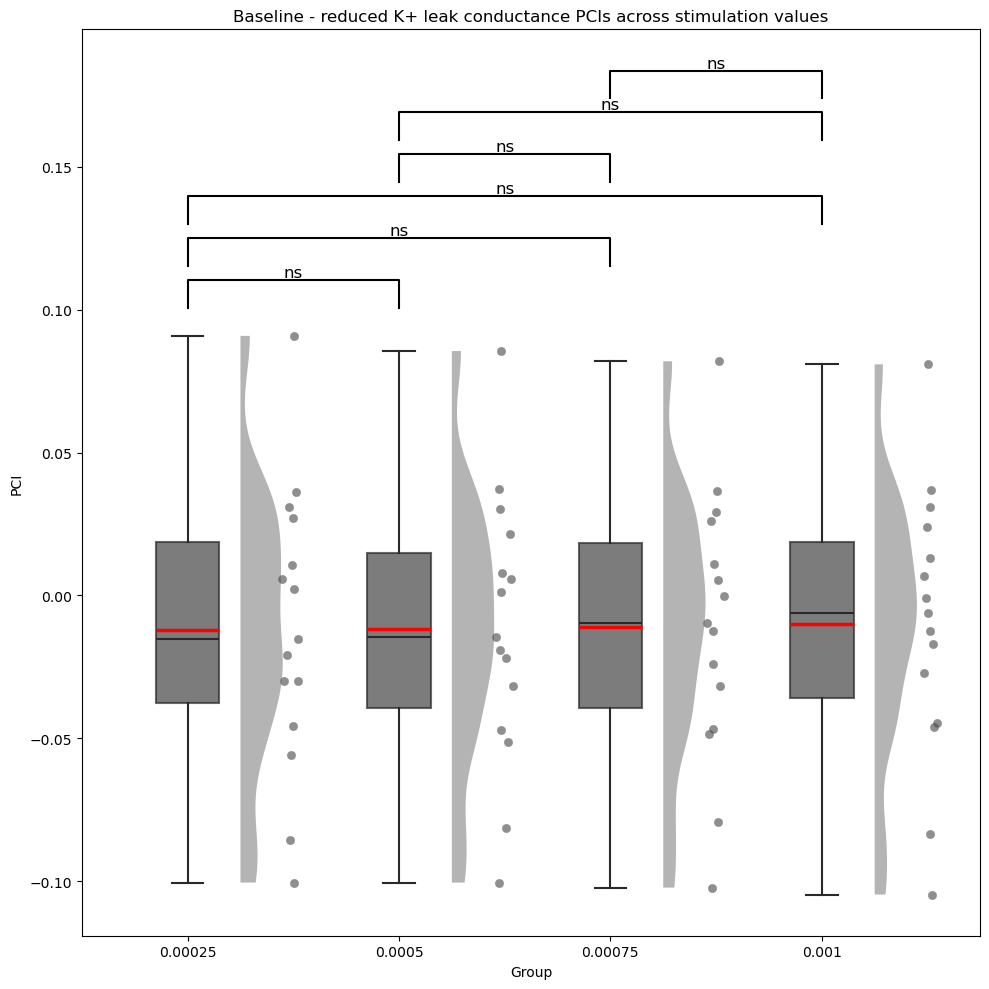

In [46]:
# Plotting differences between PCIs for each stimval

# for stimval in stimvals:
#     x.append(f'Baseline {stimval}')
# for stimval in stimvals:
#     x.append(f'Reduced K+ leak conductance {stimval}')
set_params = {
    'title': f'Baseline - reduced K+ leak conductance PCIs across stimulation values',
    'ylabel': 'PCI',
    'xlabel': 'Group'
}
colors = ['#444444']*len(stimvals) + ['#4A90E2']*len(stimvals)
plot_box_points_violin(
    simconfigs=simconfigs,
    file_prefix='PCI',
    data=pcis[:len(stimvals)]-pcis[len(stimvals):],
    n_seeds=n_minimal_seeds,
    figsize=figsize,
    save=1,
    path=simu_path,
    x=stimvals,
    save_path=img_save_path,
    file_name=f'PCI_differences_stimvals_{stimvals}.png',
    box_colors=colors,
    set_params=set_params
)